# MFG Class: Customer Forecasting

<br>

---

<br>

In this session, we're going to look at rudimentary methods of forecasting using a small dataset. There are 4 data entry points:

1. forecasted
2. ordered
3. scheduled
4. produced

**TIME LINE**

* Simple forecast w/ rolled up data
  * week 1
* More complex forecase w/ product data (+ whatever else)
  * week 2
* Product Wheel Optimization w/ the forecasted
  * weeks 3-4
  * which line to produce one, what bucket sizes
  * need transition times, product/line pairs (required and preferred)
  * production rates, deckle rates

<br>

---

<br>

<a name='top'></a>

# Contents

* 1.0 [Preparing Environment and Importing Data](#x.0)
  * 1.0.1 [Import Packages](#x.0.1)
  * 1.0.2 [Load Dataset](#x.0.2)
* 1.1 [Exploratory Data Analysis](#x.1)
  * 1.1.1 [Interactive Monthly](#x.1.1)
  * 1.1.2 [Interactive Monthly With Rolling](#x.1.2)
* 1.2 [Modeling](#x.2)
  * 1.2.1 [Symbolic Models](#x.2.1)
    * 1.2.1.1 [3 mo. Rule-Based](#x.2.1.1)
    * 1.2.1.2 [6 mo. Rule-Based](#x.2.1.2)
  * 1.2.2 [Random Forest](#x.2.2)
    * 1.2.2.1 [3 mo. Forest](#x.2.2.1)
    * 1.2.2.2 [6 mo. Forest](#x.2.2.2)
* 1.3 [Pipeline](#x.3)
<br>



---

<a name='x.0'></a>

## 1.0 Preparing Environment and Importing Data

[back to top](#top)

<a name='x.0.1'></a>

### 1.0.1 Import Packages

[back to top](#top)

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
from ipywidgets import interact, interactive, widgets
import plotly.express as px
import plotly.graph_objects as go
from sklearn.metrics import r2_score
from scipy.stats import mode

<a name='x.0.2'></a>

### 1.0.2 Load Dataset

[back to top](#top)

If you are in google colab...

In [ ]:
# Sync your google drive folder
from google.colab import drive
drive.mount("/content/drive")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_excel("/content/drive/MyDrive/mfganalytic/mfg_product_wheel/data/"\
                   "Copy of 2022 Line Mix - Without Slitter.xlsx", header=1, 
                   sheet_name='2021 Plan by Month - Details')
df.head()

,Line,Line Category,Customer,2021 Annualized Program (MTs),2021 Annualized MMsm,Product,Wt. Avg BW,Jan-Dec Total,Rate (MTs/Day),MTs/Hr,Weekly,Jan MTs,Feb MTs,Mar MTs,Apr MTs,May MTs,Jun MTs,Jul MTs,Aug MTs,Sep MTs,Oct MTs,Nov MTs,Dec MTs,Jan Capacity,Feb Capacity,Mar Capacity,Apr Capacity,May Capacity,Jun Capacity,Jul Capacity,Aug Capacity,Sep Capacity,Oct Capacity,Nov Capacity,Dec Capacity,Jan Wt. Avg BW,Feb Wt. Avg BW,Mar Wt. Avg BW,Apr Wt. Avg BW,May Wt. Avg BW,Jun Wt. Avg BW,Jul Wt. Avg BW,Aug Wt. Avg BW,Sep Wt. Avg BW,Oct Wt. Avg BW,Nov Wt. Avg BW,Dec Wt. Avg BW,Jan # of Days,Feb # of Days,Mar # of Days,Apr # of Days,May # of Days,Jun # of Days,Jul # of Days,Aug # of Days,Sep # of Days,Oct # of Days,Nov # of Days,Dec # of Days,Jan MMsm,Feb MMsm,Mar MMsm,Apr MMsm,May MMsm,Jun MMsm,Jul MMsm,Aug MMsm,Sep MMsm,Oct MMsm,Nov MMsm,Dec MMsm,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep
0,K11,STNC,ESSITY,3567.130498,281.804201,NaN,12.658188,3291.130498,45.139527,1.880814,68.598663,342.993317,136.394654,136.394654,342.993317,274.394654,274.394654,342.993317,274.394654,274.394654,342.993317,274.394654,274.394654,374.875354,190.802334,178.247793,371.990392,291.769963,282.015962,382.542823,309.173224,309.173224,391.657809,309.173224,309.173224,3.413113,2.171488,2.028607,3.311583,3.246793,3.138251,3.368101,3.402648,3.402648,3.448354,3.402648,3.402648,3.021623,2.163502,2.037415,3.365258,3.308743,3.208996,3.426013,3.449890,3.449890,3.488360,3.449890,3.449890,27.096558,10.775212,10.775212,27.096558,21.677246,21.677246,27.096558,21.677246,21.677246,27.096558,21.677246,21.677246,391.657809,309.173224,309.173224,391.657809,309.173224,309.173224,391.657809,309.173224,309.173224
1,K11,STNC,ASHLEY,2210.000000,32.500000,SB,68.000000,2150.000000,58.000000,2.416667,42.500000,152.500000,170.000000,170.000000,212.500000,170.000000,170.000000,212.500000,170.000000,170.000000,212.500000,170.000000,170.000000,214.161827,305.566855,285.460962,296.125623,232.265574,224.500832,304.525962,246.119565,246.119565,311.782012,246.119565,246.119565,8.152152,14.539399,13.582726,11.021643,10.806006,10.444757,11.209747,11.324724,11.324724,11.476846,11.324724,11.324724,2.931034,18.613035,17.528289,14.391299,14.149617,13.723056,14.651114,14.753223,14.753223,14.917737,14.753223,14.753223,2.242647,2.500000,2.500000,3.125000,2.500000,2.500000,3.125000,2.500000,2.500000,3.125000,2.500000,2.500000,311.782012,246.119565,246.119565,311.782012,246.119565,246.119565,311.782012,246.119565,246.119565
2,K11,STNC,INDUSTRY PRODUCTS,60.000000,2.000000,SMS UV WHITE - 30,30.000000,60.000000,34.080000,1.420000,42.228851,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,24.755122,0.000000,0.000000,0.000000,0.000000,0.000000,25.261448,0.000000,0.000000,0.000000,0.000000,0.000000,0.707516,0.000000,0.000000,0.000000,0.000000,0.000000,0.698185,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.536188,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,K11,STNC,FQ,2195.900275,274.487534,NaN,8.000000,2227.900275,31.965416,1.331892,42.228851,243.144257,168.915406,168.915406,211.144257,168.915406,168.915406,211.144257,168.915406,168.915406,211.144257,168.915406,168.915406,188.186562,167.331983,156.321760,162.161853,127.191344,122.939280,166.761977,134.777952,134.777952,170.735475,134.777952,134.777952,1.529141,1.699605,1.587773,1.288391,1.263184,1.220955,1.310380,1.323820,1.323820,1.341603,1.323820,1.323820,5.284317,1.199143,1.129258,0.927158,0.911588,0.884107,0.943897,0.950475,0.950475,0.961074,0.950475,0.950475,30.393032,21.114426,21.114426,26.393032,21.114426,21.114426,26.393032,21.114426,21.114426,26.393032,21.114426,21.114426,170.735475,134.777952,134.777952,170.735475,134.777952,134.777952,170.735475,134.7779

If you are serving locally...

In [ ]:
df = pd.read_excel("data/Copy of 2022 Line Mix - Without Slitter.xlsx", header=1, 
                   sheet_name='2021 Plan by Month - Details')
df.head()

,Line,Line Category,Customer,2021 Annualized Program (MTs),2021 Annualized MMsm,Product,Wt. Avg BW,Jan-Dec Total,Rate (MTs/Day),MTs/Hr,...,Dec MMsm,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep
0,K11,STNC,ESSITY,3567.130498,281.804201,NaN,12.658188,3291.130498,45.139527,1.880814,...,21.677246,391.657809,309.173224,309.173224,391.657809,309.173224,309.173224,391.657809,309.173224,309.173224
1,K11,STNC,ASHLEY,2210.000000,32.500000,SB,68.000000,2150.000000,58.000000,2.416667,...,2.500000,311.782012,246.119565,246.119565,311.782012,246.119565,246.119565,311.782012,246.119565,246.119565
2,K11,STNC,INDUSTRY PRODUCTS,60.000000,2.000000,SMS UV WHITE - 30,30.000000,60.000000,34.080000,1.420000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,K11,STNC,FQ,2195.900275,274.487534,NaN,8.000000,2227.900275,31.965416,1.331892,...,21.114426,170.735475,134.777952,134.777952,170.735475,134.777952,134.777952,170.735475,134.777952,134.777952
4,K11,STNC,DOMTAR,1800.000000,64.285714,NaN,28.000000,1800.000000,54.784698,2.282696,...,4.945055,239.862613,189.346658,189.346658,239.862613,189.346658,189.346658,239.862613,189.346658,189.346658


<a name='x.1'></a>

## 1.1 Exploratory Data Analysis

[back to top](#top)

In [ ]:
for col in df.columns:
  if ' MTs' in col:
    print(col)

Jan MTs
Feb MTs
Mar MTs
Apr MTs
May MTs
Jun MTs
Jul MTs
Aug MTs
Sep MTs
Oct MTs
Nov MTs
Dec MTs


In [ ]:
df[[col for col in df.columns if ' MTs' in col]]

,Jan MTs,Feb MTs,Mar MTs,Apr MTs,May MTs,Jun MTs,Jul MTs,Aug MTs,Sep MTs,Oct MTs,Nov MTs,Dec MTs
0,342.993317,136.394654,136.394654,342.993317,274.394654,274.394654,342.993317,274.394654,274.394654,342.993317,274.394654,274.394654
1,152.500000,170.000000,170.000000,212.500000,170.000000,170.000000,212.500000,170.000000,170.000000,212.500000,170.000000,170.000000
2,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000,30.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,243.144257,168.915406,168.915406,211.144257,168.915406,168.915406,211.144257,168.915406,168.915406,211.144257,168.915406,168.915406
4,173.076923,138.461538,138.461538,173.076923,138.461538,138.461538,173.076923,138.461538,138.461538,173.076923,138.461538,138.461538
...,...,...,...,...,...,...,...,...,...,...,...,...
112,160.000000,160.000000,180.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
113,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
114,92.307692,73.846154,73.846154,92.307692,73.846154,73.846154,92.307692,73.846154,73.846154,92.307692,73.846154,73.846154
115,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
mts = [col for col in df.columns if ' MTs' in col]

In [ ]:
df.shape

(117, 80)

In [ ]:
df.Line.nunique()

6

In [ ]:
df['Line'].unique()

array(['K11', 'K13', 'M4', 'M5', 'W13', 'W14'], dtype=object)

In [ ]:
df.Customer.nunique()

67

Jan, April, July, and Oct are higher MTs because these fiscal months are longer

<AxesSubplot:>

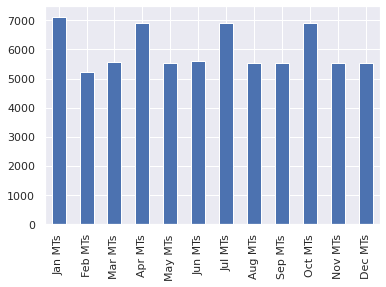

In [ ]:
df[mts].sum(axis=0).plot.bar()

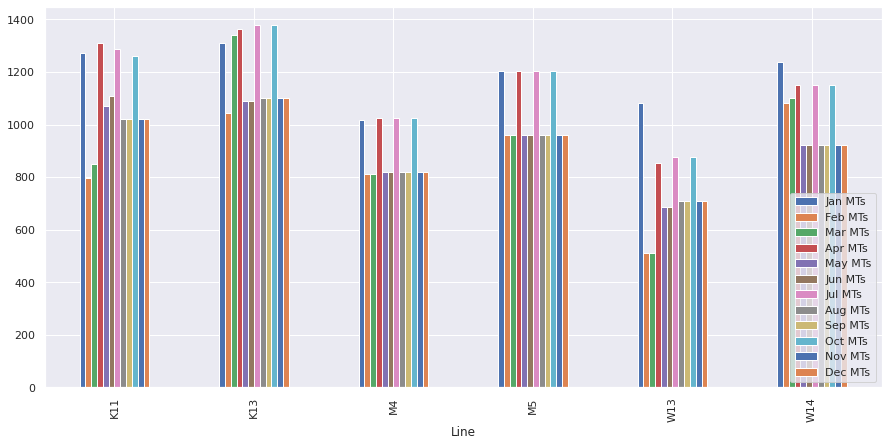

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(15,7))
df.groupby(['Line'])[mts].sum().plot.bar(ax=ax)
plt.legend(loc='lower right')

<AxesSubplot:ylabel='Customer'>

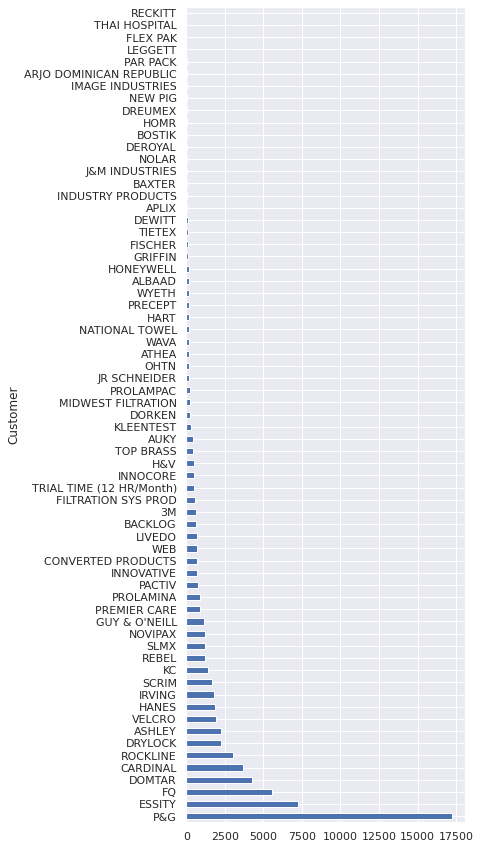

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(5,15))
df.groupby('Customer')[mts].sum().sum(axis=1).sort_values(ascending=False)\
  .plot.barh(ax=ax)

<a name='x.1.1'></a>

### 1.1.1 Interactive Monthly

[back to top](#top)

In [ ]:
customers = df.groupby('Customer')[mts].sum().sum(axis=1).\
         sort_values(ascending=False).index

def plot_monthly(customer = customers):
  # make df
  dff = df.loc[df['Customer'] == customer]
  dff = dff[['Line'] + mts].reset_index(drop=True).set_index('Line').T
  dff = dff.groupby(by=dff.columns, axis=1).sum()

  # make plot data
  data = [go.Bar(x=dff.index,
  y=dff[col],
  name=col) for col in dff.columns]

  # make plot
  fig = go.Figure(data=data)
  fig.update_layout(
    autosize=False,
    width=800,
    height=500)
  return fig

In [ ]:
interact(plot_monthly)

interactive(children=(Dropdown(description='customer', options=('P&G', 'ESSITY', 'FQ', 'DOMTAR', 'CARDINAL', '…

<function __main__.plot_monthly(customer=Index(['P&G', 'ESSITY', 'FQ', 'DOMTAR', 'CARDINAL', 'ROCKLINE', 'DRYLOCK',
       'ASHLEY', 'VELCRO', 'HANES', 'IRVING', 'SCRIM', 'KC', 'REBEL', 'SLMX',
       'NOVIPAX', 'GUY & O'NEILL', 'PREMIER CARE', 'PROLAMINA', 'PACTIV',
       'INNOVATIVE', 'CONVERTED PRODUCTS', 'WEB', 'LIVEDO', 'BACKLOG', '3M',
       'FILTRATION SYS PROD', 'TRIAL TIME (12 HR/Month)', 'INNOCORE', 'H&V',
       'TOP BRASS', 'AUKY', 'KLEENTEST', 'DORKEN', 'MIDWEST FILTRATION',
       'PROLAMPAC', 'JR SCHNEIDER', 'OHTN', 'ATHEA', 'WAVA', 'NATIONAL TOWEL',
       'HART', 'PRECEPT', 'WYETH', 'ALBAAD', 'HONEYWELL', 'GRIFFIN', 'FISCHER',
       'TIETEX', 'DEWITT', 'APLIX', 'INDUSTRY PRODUCTS', 'BAXTER',
       'J&M INDUSTRIES', 'NOLAR', 'DEROYAL', 'BOSTIK', 'HOMR', 'DREUMEX',
       'NEW PIG', 'IMAGE INDUSTRIES', 'ARJO DOMINICAN REPUBLIC', 'PAR PACK',
       'LEGGETT', 'FLEX PAK', 'THAI HOSPITAL', 'RECKITT'],
      dtype='object', name='Customer'))>

<a name='x.1.2'></a>

### 1.1.2 Interactive Monthly With Rolling

[back to top](#top)

In [ ]:
customers = df.groupby('Customer')[mts].sum().sum(axis=1).\
         sort_values(ascending=False).index
changing = []
for customer in customers:
  dff = df.loc[df['Customer'] == customer]
  dff = dff[['Line'] + mts].reset_index(drop=True).set_index('Line').T
  dff = dff.groupby(by=dff.columns, axis=1).sum()  
  if dff.sum(1).rolling(window=3).mean().round()[2:].nunique() > 1:
    changing.append(customer)

def plot_monthly(customer = changing):
  # make df
  dff = df.loc[df['Customer'] == customer]
  dff = dff[['Line'] + mts].reset_index(drop=True).set_index('Line').T
  dff = dff.groupby(by=dff.columns, axis=1).sum()

  # make plot data
  data = [go.Bar(x=dff.index,
  y=dff[col],
  name=col) for col in dff.columns]


  # make plot
  fig = go.Figure(data=data)

  # add rolling
  fig.add_trace(go.Scatter(
      x=dff.index[2:],
      y=dff.sum(1).rolling(window=3).mean().round()[2:],
      name='3 mo. rolling'
  ))
  fig.update_layout(
  autosize=False,
  width=800,
  height=500)
  return fig

In [ ]:
interact(plot_monthly)

interactive(children=(Dropdown(description='customer', options=('P&G', 'FQ', 'ASHLEY', 'SCRIM', "GUY & O'NEILL…

<function __main__.plot_monthly(customer=['P&G', 'FQ', 'ASHLEY', 'SCRIM', "GUY & O'NEILL", 'PREMIER CARE', 'INNOVATIVE', 'BACKLOG', 'TOP BRASS', 'AUKY', 'KLEENTEST', 'TIETEX', 'INDUSTRY PRODUCTS', 'NOLAR'])>

<a name='x.2'></a>

## 1.2 Modeling

[back to top](#top)

<a name='x.2.1'></a>

### 1.2.1 Symbolic Models

[back to top](#top)

With this data, we see a basic trend. Jan, Apr, Jul, Oct are long months while the remaining are short months. We would like to base our predictions on these month-specific averages.

<a name='x.2.1.1'></a>

#### 1.2.1.1 3 mo. Rule-Based

[back to top](#top)

In [ ]:
# restructure X
# 3 mo. 
# Xxx > next will be X
# xXx > next will be x
# xxX > next will be x

In [ ]:
list(range(len(mts)-3))

[0, 1, 2, 3, 4, 5, 6, 7, 8]

In [ ]:
df

,Line,Line Category,Customer,2021 Annualized Program (MTs),2021 Annualized MMsm,Product,Wt. Avg BW,Jan-Dec Total,Rate (MTs/Day),MTs/Hr,...,Dec MMsm,Jan,Feb,Mar,Apr,May,Jun,Jul,Aug,Sep
0,K11,STNC,ESSITY,3567.130498,281.804201,NaN,12.658188,3291.130498,45.139527,1.880814,...,21.677246,391.657809,309.173224,309.173224,391.657809,309.173224,309.173224,391.657809,309.173224,309.173224
1,K11,STNC,ASHLEY,2210.000000,32.500000,SB,68.000000,2150.000000,58.000000,2.416667,...,2.500000,311.782012,246.119565,246.119565,311.782012,246.119565,246.119565,311.782012,246.119565,246.119565
2,K11,STNC,INDUSTRY PRODUCTS,60.000000,2.000000,SMS UV WHITE - 30,30.000000,60.000000,34.080000,1.420000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
3,K11,STNC,FQ,2195.900275,274.487534,NaN,8.000000,2227.900275,31.965416,1.331892,...,21.114426,170.735475,134.777952,134.777952,170.735475,134.777952,134.777952,170.735475,134.777952,134.777952
4,K11,STNC,DOMTAR,1800.000000,64.285714,NaN,28.000000,1800.000000,54.784698,2.282696,...,4.945055,239.862613,189.346658,189.346658,239.862613,189.346658,189.346658,239.862613,189.346658,189.346658
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,W14,W14,INNOVATIVE,NaN,0.000000,8 gsm (STNC),8.000000,NaN,31.965416,1.331892,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
113,W14,W14,FQ,NaN,0.000000,8 gsm (STNC),8.000000,NaN,24.251000,1.010458,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
114,W13,W13,ROCKLINE,960.000000,32.000000,SOFT,30.000000,0.000000,36.878980,1.536624,...,2.461538,122.240951,96.663290,96.663290,122.240951,96.663290,96.663290,122.240951,96.663290,96.663290
115,W13,W13,GUY & O'NEILL,0.000000,0.000000,SOFT,30.000000,0.000000,36.878980,1.536624,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [ ]:
X = []
y = []
for i in range(len(mts)-3):
  X.append(df[mts[i:i+3]].values)
  y.append(df[mts[i+3]].values)
X = np.array(X).reshape(117*np.array(X).shape[0],3)
y = np.array(y).reshape(117*np.array(y).shape[0],)
X = X[np.where(~np.isnan(y))[0]]
y = y[np.where(~np.isnan(y))[0]]

labels = []
for row in X:
  labels.append("X: {}".format(np.array2string(row.round())))

In [ ]:
def sym_model(X):
  y = []
  for row in X:
    if np.argmax(row) == 0:
      y_ = np.max(row)
    else:
      y_ = np.min(row)
    y.append(y_)
  return np.array(y)

In [ ]:
pred = sym_model(X)
r2_score(y, pred)

0.9125008865155128

In [ ]:
fig = px.scatter(x=y, y=pred, hover_name=labels,
                 labels={
                     "y": "Prediction",
                     "x": "Actual"
                 })
fig.update_layout(
  autosize=False,
  width=800,
  height=500,
  title='R2: {:.3f}'.format(r2_score(y, pred))
  )

We can make slight improvements on this model by adjusting when to ignore or return 0s

In [ ]:
row = [0.01, 120, 0]
row

[0.01, 120, 0]

In [ ]:
row = [120, 0, 0]
row

[120, 0, 0]

In [ ]:
all(row[1:]) == 0

True

In [ ]:
np.min([i for i in row if round(i) > 0])

120

In [ ]:
def sym_model(X):
  y = []
  for row in X:
    if all((row[1:]) == 0) or all((row.round()) == 0):
      y_ = 0
    elif np.argmax(row) == 0:
      y_ = np.max(row)
    else:
      y_ = np.min([i for i in row if round(i) > 0])
    y.append(y_)
  return np.array(y)

In [ ]:
pred = sym_model(X)
r2_score(y, pred)

0.9657065298640993

In [ ]:
fig = px.scatter(x=y, y=pred, hover_name=labels,
                 labels={
                     "y": "Prediction",
                     "x": "Actual"
                 })
fig.update_layout(
  autosize=False,
  width=800,
  height=500,
  title='R2: {:.3f}'.format(r2_score(y, pred))
  )

<a name='x.2.1.2'></a>

#### 1.2.1.2 6 mo. Rule-Based

[back to top](#top)

In [ ]:
def process_data(window=3):
  X = []
  y = []
  for i in range(len(mts)-window):
    X.append(df[mts[i:i+window]].values)
    y.append(df[mts[i+window]].values)
  X = np.array(X).reshape(117*np.array(X).shape[0],window)
  y = np.array(y).reshape(117*np.array(y).shape[0],)
  X = X[np.where(~np.isnan(y))[0]]
  y = y[np.where(~np.isnan(y))[0]]

  labels = []
  for row in X:
    labels.append("X: {}".format(np.array2string(row.round())))
  return X, y, labels

In [ ]:
X, y, labels = process_data(window=6)

In [ ]:
X.shape

(696, 6)

In [ ]:
def sym_model6(X):
  y = []
  for row in X:
    if all((row[4:]) == 0) or all((row.round()) == 0):
      y_ = 0
    elif np.argmax(row) == 0:
      y_ = np.max(row)
    else:
      y_ = np.min([i for i in row if round(i) > 0])
    y.append(y_)
  return np.array(y)

In [ ]:
pred = sym_model6(X)
r2_score(y, pred)

0.9639865965622793

In [ ]:
fig = px.scatter(x=y, y=pred, hover_name=labels,
                 labels={
                     "y": "Prediction",
                     "x": "Actual"
                 })
fig.update_layout(
  autosize=False,
  width=800,
  height=500,
  title='R2: {:.3f}'.format(r2_score(y, pred))
  )

<a name='x.2.2'></a>

### 1.2.2 Random Forest

[back to top](#top)

Let's deviate from symbolic ai to a machine learning format. 

In [ ]:
from sklearn.ensemble import RandomForestRegressor

<a name='x.2.2.1'></a>

#### 1.2.2.1 3 mo. Forest

[back to top](#top)

In [ ]:
X, y, labels = process_data(3)

In [ ]:
clf = RandomForestRegressor(n_estimators=10)
clf.fit(X,y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
pred = clf.predict(X)

In [ ]:
fig = px.scatter(x=y, y=pred, hover_name=labels,
                 labels={
                     "y": "Prediction",
                     "x": "Actual"
                 })
fig.update_layout(
  autosize=False,
  width=800,
  height=500,
  title='R2: {:.3f}'.format(r2_score(y, pred))
  )

<a name='x.2.2.2'></a>

#### 1.2.2.2 6 mo. Forest

[back to top](#top)

In [ ]:
X, y, labels = process_data(6)

In [ ]:
clf = RandomForestRegressor(n_estimators=10)
clf.fit(X,y)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=10, n_jobs=None, oob_score=False,
                      random_state=None, verbose=0, warm_start=False)

In [ ]:
pred = clf.predict(X)

In [ ]:
fig = px.scatter(x=y, y=pred, hover_name=labels,
                 labels={
                     "y": "Prediction",
                     "x": "Actual"
                 })
fig.update_layout(
  autosize=False,
  width=800,
  height=500,
  title='R2: {:.3f}'.format(r2_score(y, pred))
  )

<a name='x.3'></a>

## 1.3 Pipeline

[back to top](#top)

In [ ]:
from sklearn.pipeline import make_pipeline

def process_data(X, window=3):
  X_ = []
  y = []
  for i in range(X.shape[1]-window):
    X_.append(X[:, i:i+window])
    y.append(X[:, i+window])
  X_ = np.array(X_).reshape(X.shape[0]*np.array(X_).shape[0],window)
  y = np.array(y).reshape(X.shape[0]*np.array(y).shape[0],)
  X_ = X_[np.where(~np.isnan(y))[0]]
  y = y[np.where(~np.isnan(y))[0]]

  labels = []
  for row in X_:
    labels.append("X: {}".format(np.array2string(row.round())))
  return X_, y, labels

def CustomerForecaster(**kwargs):
    return make_pipeline(RandomForestRegressor(**kwargs))

In [ ]:
CustomerForecaster()

Pipeline(memory=None,
         steps=[('randomforestregressor',
                 RandomForestRegressor(bootstrap=True, ccp_alpha=0.0,
                                       criterion='mse', max_depth=None,
                                       max_features='auto', max_leaf_nodes=None,
                                       max_samples=None,
                                       min_impurity_decrease=0.0,
                                       min_impurity_split=None,
                                       min_samples_leaf=1, min_samples_split=2,
                                       min_weight_fraction_leaf=0.0,
                                       n_estimators=100, n_jobs=None,
                                       oob_score=False, random_state=None,
                                       verbose=0, warm_start=False))],
         verbose=False)

In [ ]:
np.arange(5,50,5)

array([ 5, 10, 15, 20, 25, 30, 35, 40, 45])

In [ ]:
from sklearn.model_selection import GridSearchCV

param_grid = {
              'randomforestregressor__n_estimators': np.arange(5,50,5),
              'randomforestregressor__bootstrap': [True, False]
              }

grid = GridSearchCV(CustomerForecaster(), param_grid, cv=5)

In [ ]:
int(X.shape[0]*0.8)

556

In [ ]:
X[:93].shape

(93, 6)

In [ ]:
X[93:].shape

(603, 6)

In [ ]:
X = df[mts].values
np.random.seed(4)
np.random.shuffle(X)
X_train = X[:int(X.shape[0]*0.8),:]
X_test = X[int(X.shape[0]*0.8):,:]

In [ ]:
saved = {}
for window in range(2,12):
  X, y, labels = process_data(X_train, window)
  grid.fit(X, y)
  saved["window: {}".format(window)] = grid.best_params_
  saved["window: {}".format(window)]['best_score'] = grid.best_score_

In [ ]:
pd.DataFrame(saved).T.sort_values('best_score', ascending=False)

,randomforestregressor__bootstrap,randomforestregressor__n_estimators,best_score
window: 6,False,15,0.995949
window: 7,False,15,0.990685
window: 10,True,5,0.989298
window: 8,True,5,0.985411
window: 5,True,35,0.983398
window: 9,False,20,0.979392
window: 4,True,45,0.978117
window: 3,True,15,0.975358
window: 2,True,45,0.969159
window: 11,False,40,0.923819


In [ ]:
window = int(pd.DataFrame(saved).T.sort_values('best_score', ascending=False).index[0].split(' ')[1])
window

6

In [ ]:
param_grid = {
              'randomforestregressor__n_estimators': np.arange(2,15,1),
              'randomforestregressor__bootstrap': [True, False]
              }

grid = GridSearchCV(CustomerForecaster(), param_grid, cv=5)
X, y, labels = process_data(X_train, window)
grid.fit(X, y)

GridSearchCV(cv=5, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('randomforestregressor',
                                        RandomForestRegressor(bootstrap=True,
                                                              ccp_alpha=0.0,
                                                              criterion='mse',
                                                              max_depth=None,
                                                              max_features='auto',
                                                              max_leaf_nodes=None,
                                                              max_samples=None,
                                                              min_impurity_decrease=0.0,
                                                              min_impurity_split=None,
                                                              min_samples_leaf=1,
                                      

In [ ]:
print(grid.best_params_, end='\n\n')
print(grid.best_score_)

{'randomforestregressor__bootstrap': False, 'randomforestregressor__n_estimators': 12}

0.9957734471415515


In [ ]:
X_, y_, labels = process_data(X_test, window=window)
pred = grid.best_estimator_.predict(X_)
fig = px.scatter(x=y_, y=pred, hover_name=labels,
                 labels={
                     "y": "Prediction",
                     "x": "Actual"
                 })
fig.update_layout(
  autosize=False,
  width=800,
  height=500,
  title='R2: {:.3f}'.format(r2_score(y_, pred))
  )

In [ ]:
# > predict enxt month based on prior 6
# > predict nect, nect month based prior 5 + last prediction
# > continue ...
# > project out indefinitely

### References

[back to top](#top)

* [Cloud Notebook Options with Microsoft](https://notebooks.azure.com/)